# The New York Social Graph


The goal of this project was to get familar with web scraping, data cleaning, and eventually making a graph network of social connections.

[New York Social Diary](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/) is a kind-of  voyeuristic view into New York's socially well-to-do. The data forms a natural social graph for New York's social elite, and such is an interesting dataset to play with.  An example is the this page of a [run-of-the-mill holiday party](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers). Please note that these links point to the internet archive, as the original website has recently removed most of its archives. Many of the images no longer load, but all the HTML is still there.

For the purpose of this project, the photos have carefully annotated captions labeling, which implicitly imply a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, I'll assemble the social graph from photo captions for parties dated December 1, 2014 (arbitrary cut-off for filtering), and before.  Using this graph, I'll make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

I will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed.
2. Parse all of the captions on a sample page.
3. Parse all of the captions on all pages, and assemble the graph.

**Note:** This was an old project I worked on, and if I was to re-do it from scratch, my approach would be slightly different and cleaner (code wise) when it came to the names extraction portion (phase 2).

## Phase One


The first step is to crawl the data. I want photos from parties on or before December 1st, 2014. I'll get the URL's and dates from the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime as dt
import time
import re
import pandas as pd
import spacy
import numpy as np
import itertools
import operator
import seaborn as sns
import networkx as nx
sns.set()
plt.rcParams['figure.dpi'] = 144
nlp = spacy.load('en_core_web_sm')

I'll use Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  I'll start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures). I added the user-agent as requests was returning a ClientError otherwise ([stackoverflow post](https://stackoverflow.com/questions/35137724/python-requests-client-error-bad-request-but-works-after-website-has-been-open)).

In [2]:
def soupify(wbpage):
    u_a = 'Mozilla/5.0 (X11; Linux x86_64)'
    page = requests.get(wbpage, headers={"USER-AGENT":u_a})
    if page.status_code != 200:
        print(f'status code: {page.status_code}')
    _soup = BeautifulSoup(page.text, 'lxml')
    return _soup

In [ ]:
wbsite = 'https://web.archive.org/web/20190206202736/http://www.newyorksocialdiary.com/party-pictures'
soup = soupify(wbsite)

In [ ]:
print(soup.prettify())

This page has links to 50 party pages. I looked at the html to see if I can detect a pattern of where the URL's are located. It seems that the links are in the `div.views-row span.field-content a` tag. I will use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) method to get those elements.

In [3]:
def getlinks(_soup):
    link_divs = _soup.select('div.views-row span.field-content a') # The a only selects the links span
    reg_str = '<a href="(.*)">'
    print('Total links in tags:', len(link_divs))
    
    _cml =  [] # completed links
    for link in link_divs:
        cmp = re.findall(reg_str, str(link))
        #regex library takes only strins, so converted list object to string.
        _cml.append('https://web.archive.org{}'.format(cmp[0]))

    return _cml

In [ ]:
cml = getlinks(soup)
print('The length of this URL list is:', len(cml), '\n')
print('First 5  urls are:\n')
for i in cml[0:5]:
    print(i)

I also want to get the assoicated dates with these links. This requires separting the same tag into URL and date fields.I used the `datetime.strptime` to extract dates as datetime objects.

In [4]:
def getdates(_soup):
    link_divs = _soup.select('div.views-row span.field-content')  
    # Unlike getlinks(), cannot exclusively select dates
    print('Length(URL + dates):', len(link_divs), end=' ')
    ti = int(len(link_divs)/2)
    link_divs2 = [i for i in range(ti)]
    for i in link_divs2:
        link_divs2[i] = link_divs[i*2+1]

    print(';  Length(dates):', len(link_divs2))

    reg_str = '<span class="field-content">\w*,(.*)<\/span>'
    cmp= list(range(0,ti))
    cmt= list(range(0,ti))

    for i in range(0,len(link_divs2)): #needed the range function as link_divs2 is not a list
        cmp[i] = re.findall(reg_str, str(link_divs2[i]))
        cmt[i] = dt.strptime(str(cmp[i]), "[' %B %d, %Y']")


    return cmp,cmt

In [ ]:
cmp2, cmt = getdates(soup)
print('The length of this "date" list is:', len(cmp2), '\n')
print('First 5 dates are:\n', cmp2[0:5], '\n')
print('First 5 dates are:\n', cmt[0:5], '\n')

Now I'll get all of the party URLs.  After looking at the index pages and seeing that subsequent pages have `?page=i` appended, I'll write a script to loop through all the pages and extract the party URLs.

In [ ]:
cml, cmp2, cmt = [], [], []
wbsite  = 'https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures'


for i in range(0,27):
    if i == 0:
        wb2 = wbsite
    else:
        wb2 = wbsite+ f'?page={i}'
    print(f'URL count: {i}, URL page#: {i+1}')
    soup = soupify(wb2)

    cml = cml + getlinks(soup)

    cmpp2, cmtp = getdates(soup)
    cmp2 = cmp2 + cmpp2
    cmt = cmt + cmtp

    time.sleep(1) # was timing out as I may have been hitting the server too hard. Does slow down retrieval a lot.

In [ ]:
n = 0
print(cml[n], cmp2[n], cmt[n], sep='\n')

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [ ]:
df = pd.DataFrame({'date': cmt,
                   'url': cml})
df = df[df['date'] <= '2014-12-01']
df.head()

In the end, I had about 1213 pages. I saved the url list as a text file, as well as a serialized object using the `dill` package so I don't have to re-hit the server every time and just start from here. To restore the list, I can either read the `txt` file or import the `pkd` file.

In [5]:
# you want the one or the other to be commented out
#dill.dump(df, open('df_all_urls.pkd', 'wb'))
df = dill.load(open('df_all_urls.pkd', 'rb'))

## Checkpost 1: Histogram

Just to explore the data, let's see the number of parties per month. A histogram is probably the best way to visualize the data. I also output the histogram values into a tuple, if I want to look up the exact numbers, or export them.

There may be a cleverer way of changing from the full date to a year-month datetime object (for binning), but I couldn't find one, so I did a two-step procedure:

In [6]:
df['mY'] = df['date'].dt.strftime('%b-%Y')
df['mY'] = pd.to_datetime(df['mY'], format='%b-%Y')

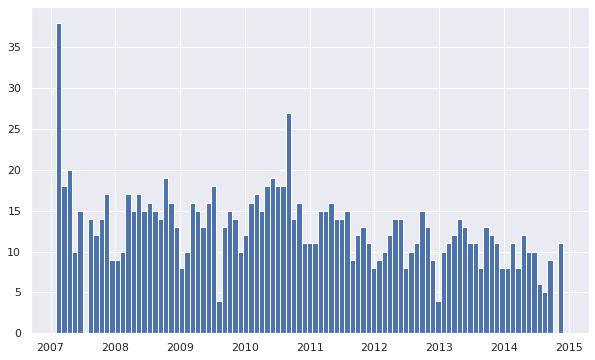

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df['mY'], bins=len(df['mY'].unique()))
plt.show()



In [ ]:
df_grp = df.groupby(['mY'], as_index=False)
grp_ct = df_grp['mY'].size().tolist()

hgram = []
for i,j in zip(df_grp, grp_ct):
    hgram.append((dt.strftime(i[0],'%Y-%m'), j))

print(len(hgram))
print(hgram[0:5])

## Phase Two

In this phase, I will concentrate on getting the names out of captions for a given page. This is not exactly a precise procedure, but the hope is to find enough structure in each page to extract the captions (via BeautifulSoup), separate multiple names (regex), and parse them out from non-name words (using the Spacy NLP library).

HTTP requests fail occasionally, I could have used the [retrying module](https://pypi.python.org/pypi/retrying) as a way to re-try a failed request, but in my case almost all of the pages were collected, so I didn't bother implementing it.

In [ ]:
# getting the url list for parsing
url_list = df['url'].tolist()
fid = open('url.txt', 'w')

for i in url_list:
    fid.write(f'{i}\n')

In [17]:
# you want the one or the other to be commented out
# dill.dump(url_list, open('url_list.pkd', 'wb'))
url_list = dill.load(open('url_list.pkd', 'rb'))

In [18]:
# Need this function as soup objects don't serialize well. 
# So I'll scrape the individual pages and save them for offline access

def pre_soup(wbpage):
    u_a = 'Mozilla/5.0 (X11; Linux x86_64)'
    page = requests.get(wbpage, headers={"USER-AGENT":u_a})
    if page.status_code != 200:
        print(f'status code: {page.status_code}')
    return page.text


In [ ]:
all_pages = []
for i,j in enumerate(url_list):
    all_pages.append(pre_soup(j))
    if i%10 == 0:
        print(i)

I am saving the retrieved pages before I use the `BeautifulSoup`. This is mostly because [serializing Soup objects can lead to failures](https://stackoverflow.com/questions/24563148/beautifulsoup-object-will-not-pickle-causes-interpreter-to-silently-crash), so its easier to save the retrieved pages. Another option is to use a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) to automate this for me by adding a decorator.

In [19]:
# dill.dump(all_pages, open('all_pages.pkd', 'wb'))
all_pages = dill.load(open('all_pages.pkd', 'rb'))

Similar to extracting the links, I'll be extracting captions from the pages now. Based on inspecting various pages, I realized that in most cases the tag `<div>` contains the captions. However, in a large minority of pages, the captions are found in the `<td>` tag, so have to select those elements as well. I used the site https://regexr.com/ to check my regular expressions before using them here.

In [20]:
    def getcaptions(_soup):
        link_td = _soup.select('td.photocaption') # For graph 2 question
        link_div = _soup.select('div.photocaption')  # For graph 2 question alternate selection
        all_links = link_td + link_div
        
        pat_div = '<div.*?>(.*)<\/div>'
        pat_td = '<td.*?>(.*)<\/td>'
        cml = []
        
        for i in all_links:
            cmp = re.findall(pat_div, str(i))
            if not cmp:
                cmp = re.findall(pat_td, str(i))
            cml.append(cmp)

        return cml

Now the hardest part of this business; that is parsing out all the names from these captions. My approach was more or less the following:
1. Cut off captions that are long (>250 characters) as they tend to be more descriptive than named captions.
2. Clean up stray spacing, prefixes, suffixes, etc.
3. Split names, couple names, and other formatting quirks with regular expressions.
4. Use SpaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) to select proper nouns as names

To be honest this is a painful process that you can work till perfection, but my goal is to get a solid working parser and refine it until I feel it's getting more than 85% of the cases on randomly selected pages.

The function below is the first pass cleaning of each tag. It just strips the most common 'dirtyness' of the data (extra spacing, prepositions, ending descriptions).

In [21]:
def strip_clean(_cmp):
    for i in _cmp:
        if not i: #added this as otherwise indexing would choke on an empty list item
            #print('cmp[',i,'] is an empty array')
            continue
        elif len(i[0]) > 250:
            #print('Greater than 250 characters. skipping it')
            continue
        else:
            reg_str = '^\s'
            i[0] = re.sub(reg_str, '', i[0])

            reg_str = '\s$'
            i[0] = re.sub(reg_str, '', i[0])

            if ' at ' in i[0]:
                reg_str = '\sat\s.*'
                i[0] = re.sub(reg_str, '', i[0])

            if '(' in i[0]:
                #print('Removed a parenthesis from ', i)
                reg_str = '\(.*\)'
                i[0] = re.sub(reg_str, '', i[0])

            if 'and friend' in i[0]:
                #print("Removing 'and friend(s)' from this item:", i)
                reg_str = '\sand\sfriends*'
                i[0] = re.sub(reg_str, '', i[0])
            
            if '<' in i[0]:
                #print('Removed a parenthesis from ', i)
                reg_str = '<.*>'
                i[0] = re.sub(reg_str, '', i[0])
    return _cmp

In [22]:
def split_names(cmp):
    nms = {}
    for i in range(0,len(cmp)): # putting each name into its own list
        nms[i] = {}
        # print(i)
        if not cmp[i]: #added this as otherwise indexing would choke on an empty list item
            continue
            #print('cmp[',i,'] is an empty array')
        elif len(cmp[i][0]) > 250:
            continue
            #print('Greater than 250 characters. skipping it')
        elif not(',' in cmp[i][0]):
            # not the cleverest code here, but I run the same cleaning on single names and multiple names (down below)
            if ' Jr.' in cmp[i][0]: #added this to deal with ,Jr. supposedly
                #print("Removing ' Jr. ' from this item:", cmp[i][0])
                reg_str = '\sJr\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' MD' in cmp[i][0]:
                #print("Removing 'MD ' from this item:", cmp[i][0])
                reg_str = '\sMD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M.D.' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\.D\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M D' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\sD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            reg_str = '^([^\s]+)\s+and\s+([^\s]+)\s+([^\s]+)$' # separating 'first and first last' name format
            if not(' and ' in cmp[i][0]): # means just a single name in this caption
                nms[i][0] = (cmp[i][0])
            elif re.search(reg_str, cmp[i][0]):
                rout = re.findall(reg_str, cmp[i][0])
                nms[i] = {}
                nms[i][0] = rout[0][0] + ' ' + rout[0][2]
                nms[i][1] = rout[0][1] + ' ' + rout[0][2]
                #print('Split this first and first last name for', i)
            else:
                #print('Split these two names caption for', i, cmp[i])
                ln1 = cmp[i][0].split(' and ') #list of names 1 and 2
                nms[i] = {}
                nms[i][0] = ln1[0]
                nms[i][1] = ln1[1]
        else:
            if ' Jr.' in cmp[i][0]: #added this to deal with ,Jr. supposedly
                #print("Removing ' Jr. ' from this item:", cmp[i][0])
                reg_str = '\sJr\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if 'MD' in cmp[i][0]:
                #print("Removing 'MD ' from this item:", cmp[i][0])
                reg_str = '\sMD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if 'M.D.' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\.D\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M D' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\sD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])
            
            ln = cmp[i][0].split(', ') # list of names assuming separated by comma
            for j in range(0,len(ln)):
                if 'and ' in ln[j]:
                    ln[j] = re.sub('and\s', '', ln[j])
                nms[i][j] = ln[j]
    return nms

In [23]:
def clean_things2(nmi):
    
    reg_str = '<.*?>'
    nmi = re.sub(reg_str, '', nmi)
    
    if 'and ' in nmi:
        #print("Removing 'and' from from of this item:", nmi)
        reg_str = '^and\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'with ' in nmi:
        #print("Removing 'with' from from of this item:", i, nmi)
        reg_str = ' with '
        nmi = nmi.split(reg_str)

    if 'Mayor ' in nmi:
        #print("Removing 'Mayor ' from this item", nmi)
        reg_str = '^Mayor\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'President ' in nmi:
        #print("Removing 'President ' from this item", nmi)
        reg_str = '^President\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Consul General ' in nmi:
        #print("Removing 'Consul General ' from this item", nmi)
        reg_str = '^Consul General\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Sir ' in nmi:
        #print("Removing 'Sir ' from this item", nmi)
        reg_str = '^Sir\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'HRH Princess ' in nmi:
        #print("Removing 'HRH Princess ' from this item", nmi)
        reg_str = '^HRH\sPrincess\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Ambassador ' in nmi:
        #print("Ambassador ' from this item", nmi)
        reg_str = '^Ambassador\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Dr. ' in nmi:
        #print("Removing 'Dr. ' from this item", nmi)
        reg_str = '^Dr\.\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Mr. ' in nmi:
        #print("Removing 'Mr. ' from this item:", nmi)
        reg_str = '^Mr\.\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Mrs. ' in nmi:
        #print("Removing 'Mrs. ' from this item:", nmi)
        reg_str = '^Mrs\.\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Esq.' in nmi:
        #print("Removing 'Esq. ' from this item:", nmi)
        reg_str = '\s*Esq\.$'
        nmi = re.sub(reg_str, '', nmi)

    # if 'MD' in nmi:
    #     #print("Removing 'MD ' from this item:", nmi)
    #     reg_str = '\sMD$'
    #     nmi = re.sub(reg_str, '', nmi)

    if 'M.D.' in nmi:
        #print("Removing 'M.D. ' from this item:", nmi)
        reg_str = '\s*M\.D\.$'
        nmi = re.sub(reg_str, '', nmi)

    if 'Jr.' in nmi:
        #print("Removing 'Jr. ' from this item:", nmi)
        reg_str = '\s*Jr\.$'
        nmi = re.sub(reg_str, '', nmi)

    if ' on ' in nmi:
        #print("Removing anything after ' on ' from this item:", nmi)
        reg_str = '\son\s.*$'
        nmi = re.sub(reg_str, '', nmi)

    if ' examining ' in nmi:
        #print("Removing anything after ' examining ' from this item:", nmi)
        reg_str = '\sexamining\s.*$'
        nmi = re.sub(reg_str, '', nmi)

    if 'Mr.' in nmi or 'Mrs.' in nmi: #order matters, after the other Mrs. one
        #print("Deleting this entry:", i,',',nmi)
        #del nmi
        nmi = {}

    return nmi

At some point I changed my representation of how I'm storing the files. The function `clean_things2` was written after that adjustment, so I have to loop through each dictionary item individually, unlike the above functions. I have the older `clean_things()` function preserved at the end of the notebook as an archive.

Also because of that change in approach, I had to write some code to sort out lists being generated instead of dictionary items.

In [25]:
def cleaning_and_splitting(nms):
    for i in nms:
        for j in nms[i]:
            #print(i,j)
            nms[i][j] = clean_things2(nms[i][j])

    nmi_temp = {}
    for i in nms:
        for j in nms[i]:
            if type(nms[i][j]) is list:
                nmi_temp[int(i)] = {int(j): nms[i][j]}

    nmi_split = {}
    for i in nmi_temp:
        nmi_split[i] = {}
        for j in nmi_temp[i]:
            n = len(nms[i])
            for k in nmi_temp[i][j]:
                nmi_split[i][n] = k
                n += 1

    for i in nmi_temp:
        for j in nmi_temp[i]:
            del(nms[i][j])

    for i in nmi_split:
        for j in nmi_split[i]:
            nms[i][j] = nmi_split[i][j]
    
    return nms

This bit here uses the NLP function above to generate a list of dictionary items that should be deleted.

In [24]:
    def sp_nlp(nmi):
        doc = nlp(nmi)
        in_tok_n = [] #token is noun
        tok_n = np.array(in_tok_n)
        j = 0
        deli = 0
        for token in doc:
            if token.pos_ == 'PROPN':
                tok_n = np.append(tok_n, 1)
            else:
                #tok_n[j] = 0
                tok_n = np.append(tok_n, 0)
            j = j+1

        if np.mean(tok_n) < 0.5:
            #print('\n', token.text, '\n', token.pos_, '\n', nmi)
            deli = 1 #delete_item
        return deli

In [75]:
def cleaning_nlp(nms):

    del_ar = []

    for m,i in nms.items():
        for j,k in i.items():
            
            if k is str: #if its not a string (so empty dict or list, sp_nlp chokes)    
                deli = sp_nlp(k)
                if deli == 1:
                    del_ar.append([m,j])

    for i in del_ar:
        del nms[i[0]][i[1]]

    return nms

This 'cleans up' the dictionary so the keys are sequential. I don't think it really matters, but I added it for some reason, and see no reason to delete it right now.

In [27]:
def reordering_nms(nms):

    for l,i in nms.items():
        k = 0
        new_dict = {}
        for j in i:
            new_dict[k] = i[j]
            k += 1
        nms[l] = new_dict
    
    return nms

In [28]:
def scrape_and_extract(page):

    soup = BeautifulSoup(page, 'lxml')
    cmp = getcaptions(soup)
    cmp = strip_clean(cmp)
    nms = split_names(cmp)
    nms = cleaning_and_splitting(nms)
    nms = cleaning_nlp(nms)
    nms = reordering_nms(nms)
    
    return nms

In [89]:
nmp = []

for h,k in enumerate(all_pages):
    print(f'{h} ', end='')
    if h%20 == 0:
        print('')
        
    nms = scrape_and_extract(k)

    for i in nms.values():
        nmj = list(itertools.combinations(i.values(), 2))
        for j in nmj:
            nmp.append(j)


0 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 
81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 
221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 
241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 
261 262 263 264 265 266 267 268 269 270 271 272 273 

In [91]:
dill.dump(nmp, open('paired_list.pkd', 'wb'))
#nmp = dill.load(open('paired_list.pkd', 'rb'))

All in all, I end up with about 200,000 pairs.

## Phase 3

Now that the hard part of scraping, extracting, and parsing has been done, we can get to the fun part of using a [network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29) to tease out relationships. Any time a pair of people appear in a photo together, that is considered a link. I'll use an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph) to analyze the social graph of the New York social elite.

## Checkpoint 3: degree


The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.

In [110]:

G=nx.Graph()

for i in nmp:
    #print(i)
    if type(i) is tuple:
        if (type(i[0]) is str) & (type(i[1]) is str):
            if G.has_edge(i[0],i[1]):
                G.edges[i[0], i[1]]['weight'] += 1
                    #print(G.edges[i[0], i[1]]['weight'])
            else:
                G.add_edge(*i, weight = 1)


In [ ]:
nd = G.degree
sorted_nd = sorted(nd, key=operator.itemgetter(1))
sorted_nd.reverse()
print(sorted_nd[0:100])

nd_50 = []
for i in sorted_nd:
    nd_50.append((i[0], int(i[1])))

In [123]:
for i in nd_50[0:20]:
    print(i)

('Jean Shafiroff', 393)
('Mark Gilbertson', 321)
('Geoffrey Bradfield', 211)
('Alexandra Lebenthal', 195)
('Gillian Miniter', 191)
('Mario Buatta', 183)
('', 182)
('Michael Bloomberg', 175)
('Alina Cho', 173)
('Somers Farkas', 165)
('Sharon Bush', 165)
('Yaz Hernandez', 164)
('Debbie Bancroft', 163)
('Andrew Saffir', 162)
('Kamie Lightburn', 162)
('Lucia Hwong Gordon', 156)
('Patrick McMullan', 152)
('Muffie Potter Aston', 150)
('Allison Aston', 148)
('Eleanora Kennedy', 146)


## Checkpoint 4: PageRank


A similar way to determine popularity is to look at their
[PageRank](http://en.wikipedia.org/wiki/PageRank).  PageRank is used for web ranking and was originally
[patented](http://patft.uspto.gov/netacgi/nph-Parser?patentnumber=6285999) by Google and is essentially the stationary distribution of a [Markov
chain](http://en.wikipedia.org/wiki/Markov_chain) implied by the social graph. I will use `networkx` to generate PageRank.

In [ ]:
pr = nx.pagerank(G)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
sorted_pr.reverse()

In [122]:
for i in sorted_pr[0:20]:
    print(i)

('Jean Shafiroff', 0.0006507011754273504)
('Mark Gilbertson', 0.0004984080212498609)
('Gillian Miniter', 0.00038321998504372147)
('Geoffrey Bradfield', 0.00038221409511807604)
('', 0.0003655104723724084)
('Alexandra Lebenthal', 0.0003438944542726845)
('Andrew Saffir', 0.0003012030793997263)
('Mario Buatta', 0.00028958926734024416)
('Sharon Bush', 0.00028903557006286176)
('Yaz Hernandez', 0.00028669585161091395)
('Debbie Bancroft', 0.0002854868254226499)
('Kamie Lightburn', 0.0002672859834960708)
('Michael Bloomberg', 0.0002668840714577366)
('Alina Cho', 0.0002638994428635821)
('Somers Farkas', 0.00026340644679931255)
('Eleanora Kennedy', 0.00024923599735766374)
('PhD', 0.00023915693496326398)
('Lucia Hwong Gordon', 0.00023762697337202318)
('friends', 0.00023466434535043677)
('Barbara Tober', 0.0002298265770105754)


## Checkpoint 5: best_friends


Another interesting question is who tend to hangout with whom, the most. This can be determined by sorting edges with the highest weights. I have just printed the top 20.

In [ ]:
ct = 0
bf = []
for (u,v,d) in G.edges(data='weight'):
    if d >9:
        #print(u, v, d)
        bf.append(((u, v), d))
        ct += 1

sorted_bf = sorted(bf, key=operator.itemgetter(1))
sorted_bf.reverse()

In [121]:
for i in sorted_bf[0:20]:
    print(i)

(('Gillian Miniter', 'Sylvester Miniter'), 97)
(('Bonnie Comley', 'Stewart Lane'), 68)
(('Jamee Gregory', 'Peter Gregory'), 61)
(('Geoffrey Bradfield', 'Roric Tobin'), 61)
(('Daniel Benedict', 'Andrew Saffir'), 58)
(('Somers Farkas', 'Jonathan Farkas'), 43)
(('Alexandra Lebenthal', 'Jay Diamond'), 42)
(('Barbara Tober', 'Donald Tober'), 41)
(('Jean Shafiroff', 'Martin Shafiroff'), 41)
(('Sessa von Richthofen', 'Richard Johnson'), 34)
(('Yaz Hernandez', 'Valentin Hernandez'), 34)
(('Chappy Morris', 'Melissa Morris'), 33)
(('Campion Platt', 'Tatiana Platt'), 32)
(('Deborah Norville', 'Karl Wellner'), 32)
(('Barbara Regna', 'Peter Regna'), 32)
(('Guy Robinson', 'Elizabeth Stribling'), 32)
(('Margo Catsimatidis', 'John Catsimatidis'), 31)
(('Jonathan Tisch', 'Lizzie Tisch'), 31)
(('Hilary Geary Ross', 'Wilbur Ross'), 30)
(('Eleanora Kennedy', 'Michael Kennedy'), 29)


## Code not used

In [ ]:
def clean_things(nms):


    for i in nms:
        if 'and ' in nms[i]:
            print("Removing 'and' from from of this item:", nms[i])
            reg_str = '^and\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'with ' in nms[i]:
            print("Removing 'with' from from of this item:", nms[i])
            reg_str = ' with '
            nms[i], nms[nml] = nms[i].split(reg_str)

        if 'Dr. ' in nms[i]:
            print("Removing 'Dr. ' from this item", nms[i])
            reg_str = '^Dr\.\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'Mr. ' in nms[i]:
            print("Removing 'Mr. ' from this item:", nms[i])
            reg_str = '^Mr\.\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'Mrs. ' in nms[i]:
            print("Removing 'Mrs. ' from this item:", nms[i])
            reg_str = '^Mrs\.\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'Esq.' in nms[i]:
            print("Removing 'Esq. ' from this item:", nms[i])
            reg_str = '\s*Esq\.$'
            nms[i] = re.sub(reg_str, '', nms[i])

        if ' on ' in nms[i]:
            print("Removing anything after ' on ' from this item:", nms[i])
            reg_str = '\son\s.*$'
            nms[i] = re.sub(reg_str, '', nms[i])
            
    return nms